In [1]:
import numpy as np
import pandas as pd
import psycopg2
import getpass
# for configuring connection 
from configobj import ConfigObj
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = '192.168.60.144'
    conn_info["sqlport"] = 6432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == '192.168.60.144') & (conn_info["sqlport"]=='6432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [3]:
from sqlalchemy import create_engine,text

con = create_engine(
    f'postgresql://{conn_info["sqluser"]}:{conn_info["sqlpass"]}@{conn_info["sqlhost"]}:{conn_info["sqlport"]}/{conn_info["dbname"]}',
    connect_args={'options': '-c search_path=eicu_crd'}
)

In [4]:
def plot_counts(counts, title):
    # Create a DataFrame from the counts Series
    plt.figure(figsize=(12, 6))
    df_plot = pd.DataFrame({
         title: counts.index,
        "counts": counts.values
    })
    ax = sns.barplot(data=df_plot,
                        x=title,
                        y="counts",
                        palette="pastel",
                        hue=title,
                        dodge=False)
    
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}', 
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 9),
                    textcoords='offset points',
                    ha='center', va='bottom')
        
    plt.xticks(rotation=45, ha="right") 
    plt.show()

In [54]:
query =query_schema + """

SELECT distinct(l.*)
FROM labels AS l
INNER JOIN vitalp AS vp ON l.patient = vp.patient
WHERE l.unitdischargeoffset > 360

"""

df_an_6 = pd.read_sql_query(query,con)
print("there are {} patients in the  and {} records in flat".format(df_an_6['patient'].nunique(), df_an_6.shape[0]))

there are 3054 patients in the  and 3054 records in flat


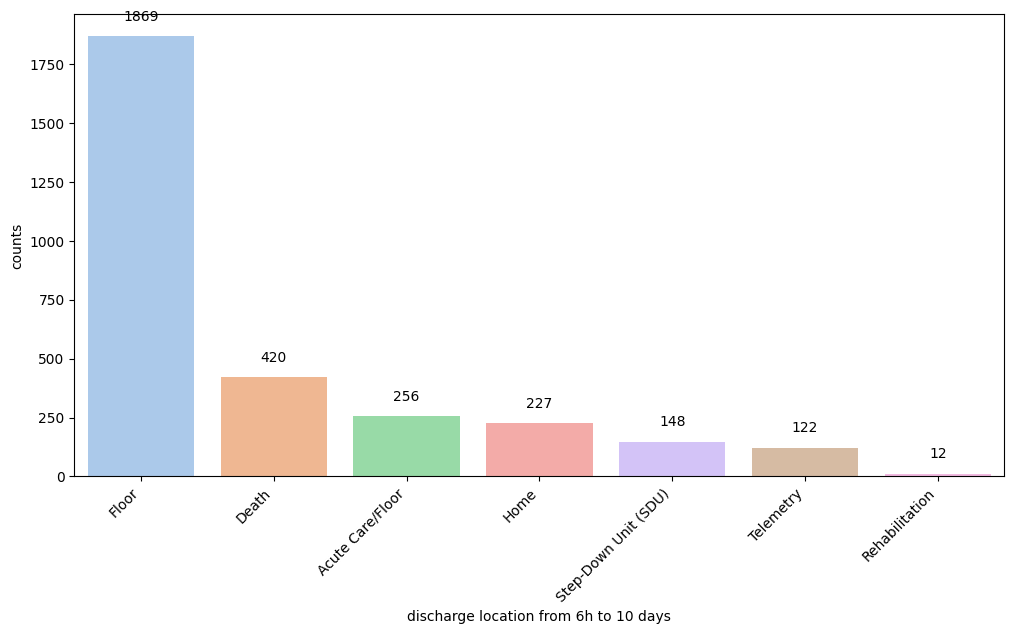

In [55]:
count_6 = df_an_6['unitdischargelocation'].value_counts()
plot_counts(count_6, 'discharge location from 6h to 10 days')

In [56]:
query =query_schema + """

SELECT distinct(l.*)
FROM labels AS l
INNER JOIN vitalp AS vp ON l.patient = vp.patient
WHERE l.unitdischargeoffset > 720

"""

df_an_12 = pd.read_sql_query(query,con)
print("there are {} patients in the  and {} records in flat".format(df_an_12['patient'].nunique(), df_an_12.shape[0]))

there are 3006 patients in the  and 3006 records in flat


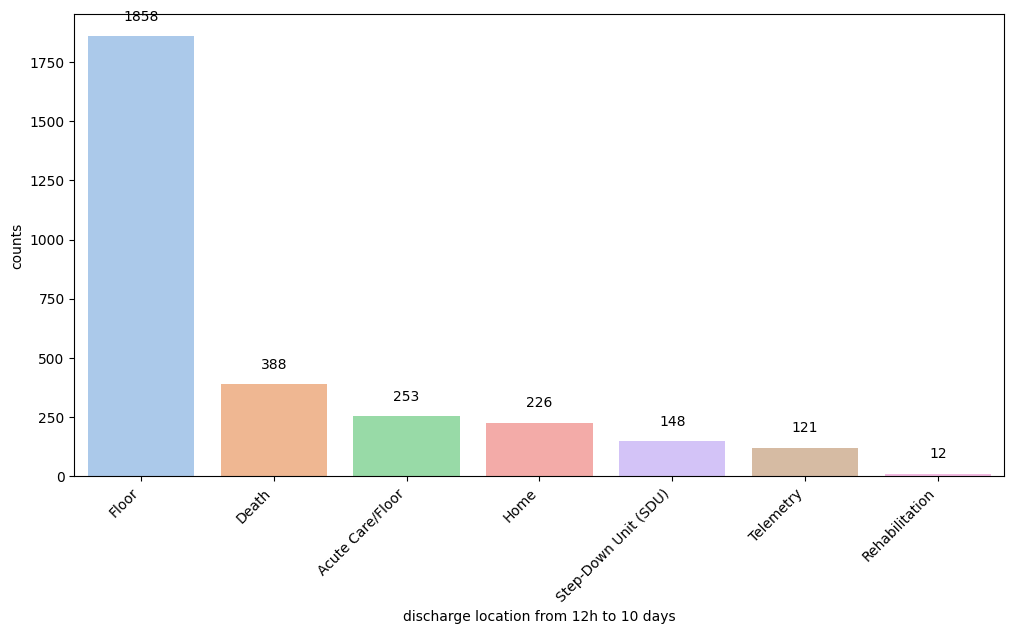

In [57]:
count_12 = df_an_12['unitdischargelocation'].value_counts()
plot_counts(count_12, 'discharge location from 12h to 10 days')